## Import Libraries

In [1]:
# Add package to path
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

import numpy as np
import matplotlib.pyplot as plt
from galform_analysis.config import get_base_dir, get_snapshot_redshift
from galform_analysis.analysis.smf import compute_smf_avg_by_snapshot
#from galform_analysis.analysis.hmf import compute_hmf_avg_by_snapshot

# Set up plotting
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# The BASE_DIR is already configured in config.py
base_dir = get_base_dir()

## For a given redshift and sub volume, plot the HMF

Redshift z = 0.496
Volume V_ivol = 1.556e+05 Mpc^3
Total halos counted: 62088


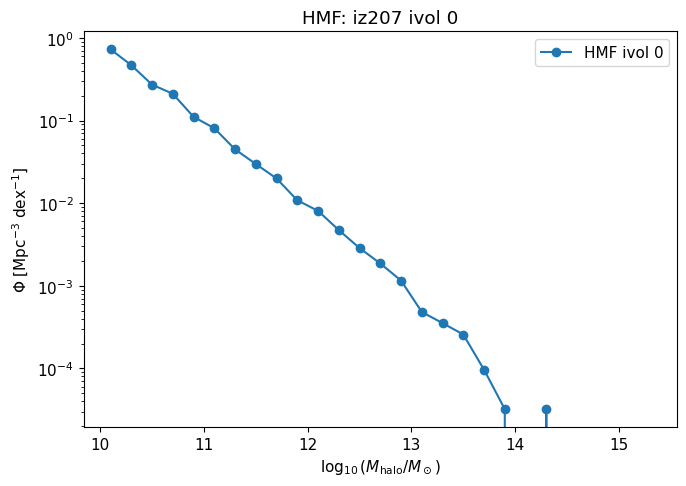

In [2]:
from galform_analysis.analysis.hmf import hmf_given_redshift_and_subvolume

example_snapshot = 'iz207'
example_ivol = 0  

result = hmf_given_redshift_and_subvolume(str(base_dir / example_snapshot), example_ivol)

if result is None:
    print("No valid HMF data for this (snapshot, ivol). Try another ivol or snapshot.")
else:
    z_val = result.get('z')
    centers = result['centers']
    phi = result['phi']
    counts = result['counts']
    V_ivol = result.get('V_ivol')

    if z_val is not None:
        print(f"Redshift z = {z_val:.3f}")
    if V_ivol is not None:
        print(f"Volume V_ivol = {V_ivol:.3e} Mpc^3")
    print(f"Total halos counted: {counts.sum()}")

    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_yscale('log')
    ax.plot(centers, phi, 'o-', label=f'HMF ivol {example_ivol}')

    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$')
    ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]')
    title = f"HMF: {example_snapshot} ivol {example_ivol}"
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

## For a given redshift and subvolume, compare to theoretical HMFs

Redshift z = 0.496
Subvolume V_ivol = 1.556e+05 Mpc^3
Total halos counted: 62088


/cosma/home/durham/dc-hick2/galform_analysis/.venv/lib64/python3.9/site-packages/hmf/density_field/transfer_models.py:232: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


Cosmology: h=0.677, Omega_m=0.310


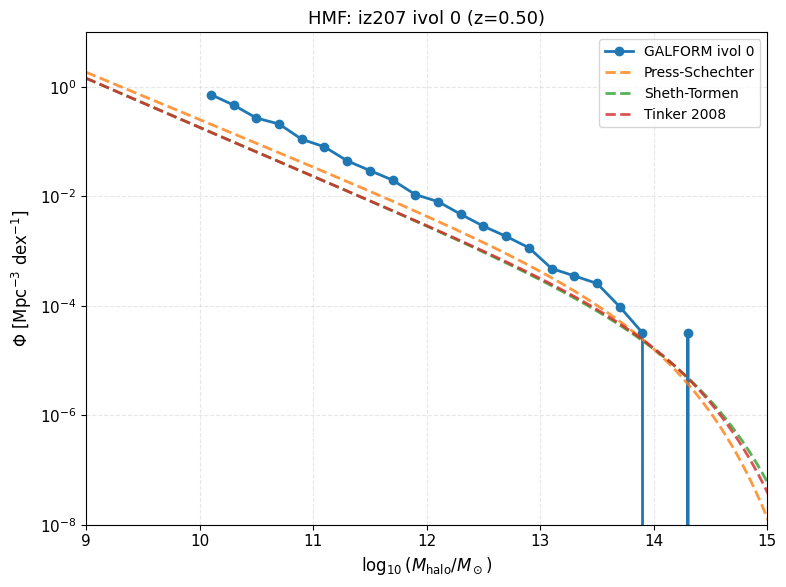

In [3]:
# Reload the loaders module to pick up the volume fix
import importlib
import galform_analysis.io.loaders as loaders_mod
importlib.reload(loaders_mod)

from galform_analysis.analysis.hmf import hmf_given_redshift_and_subvolume

example_snapshot = 'iz207'
example_ivol = 0  

result = hmf_given_redshift_and_subvolume(str(base_dir / example_snapshot), example_ivol)

if result is None:
    print("No valid HMF data for this (snapshot, ivol). Try another ivol or snapshot.")
else:
    z_val = result.get('z')
    centers = result['centers']
    phi = result['phi']
    counts = result['counts']
    V_ivol = result.get('V_ivol')

    if z_val is not None:
        print(f"Redshift z = {z_val:.3f}")
    if V_ivol is not None:
        print(f"Subvolume V_ivol = {V_ivol:.3e} Mpc^3")
    print(f"Total halos counted: {counts.sum()}")

    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_yscale('log')
    
    # Plot simulation data
    ax.plot(centers, phi, 'o-', label=f'GALFORM ivol {example_ivol}', linewidth=2, markersize=6, color='C0')

    # Add theoretical HMF curves
    try:
        from hmf import MassFunction
        
        # Create mass function object at the simulation redshift
        hmf_calc = MassFunction(z=z_val, Mmin=9, Mmax=16, dlog10m=0.01)
        
        # Get mass array in same units as simulation (M_sun)
        M_theory = hmf_calc.m  # Mass in M_sun
        log10M_theory = np.log10(M_theory)
        
        # Press-Schechter
        hmf_calc.update(hmf_model="PS")
        dndlog10m_ps = hmf_calc.dndlog10m  # dn/dlog10M in (Mpc/h)^-3
        h = hmf_calc.cosmo.h  # Hubble parameter
        phi_ps = dndlog10m_ps * h**3  # Convert to Mpc^-3
        ax.plot(log10M_theory, phi_ps, '--', label='Press-Schechter', linewidth=2, alpha=0.8, color='C1')
        
        # Sheth-Tormen
        hmf_calc.update(hmf_model="SMT")
        dndlog10m_st = hmf_calc.dndlog10m
        phi_st = dndlog10m_st * h**3
        ax.plot(log10M_theory, phi_st, '--', label='Sheth-Tormen', linewidth=2, alpha=0.8, color='C2')
        
        # Tinker 2008
        hmf_calc.update(hmf_model="Tinker08")
        dndlog10m_tinker = hmf_calc.dndlog10m
        phi_tinker = dndlog10m_tinker * h**3
        ax.plot(log10M_theory, phi_tinker, '--', label='Tinker 2008', linewidth=2, alpha=0.8, color='C3')
        
        print(f"Cosmology: h={h:.3f}, Omega_m={hmf_calc.cosmo.Om0:.3f}")
        
    except ImportError:
        print("Note: 'hmf' package not installed. Install with: pip install hmf")
        print("Theoretical curves will not be shown.")
    except Exception as e:
        print(f"Warning: Could not compute theoretical HMF: {e}")

    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$', fontsize=12)
    ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]', fontsize=12)
    title = f"HMF: {example_snapshot} ivol {example_ivol} (z={z_val:.2f})"
    ax.set_title(title, fontsize=13)
    ax.set_xlim(9, 15)
    ax.set_ylim(1e-8, 1e1)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.show()

## HMFs for different redshifts

Computing HMF for ivol=8 at 4 redshifts


Successfully loaded 3 snapshots


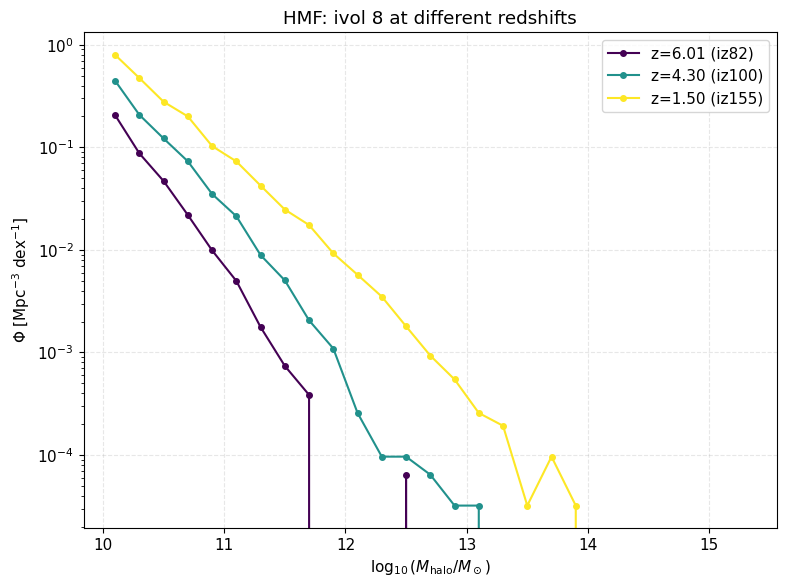

In [4]:
# Example: HMF for one subvolume at multiple redshifts (plotted separately, not averaged)
from galform_analysis.analysis.hmf import hmfs_given_redshifts_and_subvolume
import pandas as pd

example_ivol = 8
iz_nums = [82, 100, 120, 155]  # subset for faster testing

print(f"Computing HMF for ivol={example_ivol} at {len(iz_nums)} redshifts")

# Collect results for each redshift
df, results_by_z = hmfs_given_redshifts_and_subvolume(example_ivol, iz_nums, base_dir=base_dir)
    
# Plot each redshift separately on same axes
fig, ax = plt.subplots(figsize=(8,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(results_by_z)))

for res, color in zip(results_by_z, colors):
    label = f"z={res['z']:.2f} ({res['iz']})"
    ax.plot(res['centers'], res['phi'], 'o-', label=label, color=color, markersize=4)

ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$')
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]')
ax.set_title(f"HMF: ivol {example_ivol} at different redshifts")
ax.grid(alpha=0.3, linestyle='--')
ax.legend()
plt.tight_layout()
plt.show()

## For a given sub volume average over given redshifts

Computing HMF for ivol=1 across 5 redshifts
Successfully used 4/5 snapshots
Snapshots: ['iz82', 'iz120', 'iz155', 'iz207']
Redshifts: ['6.01', '3.05', '1.50', '0.50']
Successfully used 4/5 snapshots
Snapshots: ['iz82', 'iz120', 'iz155', 'iz207']
Redshifts: ['6.01', '3.05', '1.50', '0.50']


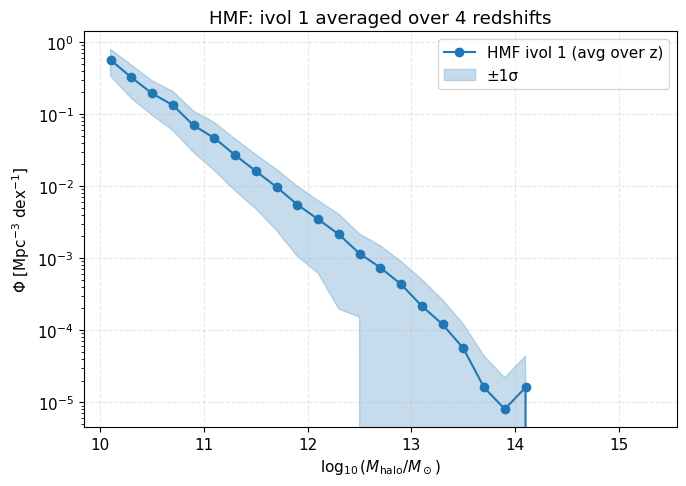

In [5]:
# Example: Average HMF for one subvolume across multiple redshifts
from galform_analysis.analysis.hmf import avg_hmf_given_redshifts_and_subvolume

example_ivol = 1  # choose a subvolume
iz_nums = [82, 100, 120, 155, 207]  # snapshots that exist in base_dir

print(f"Computing HMF for ivol={example_ivol} across {len(iz_nums)} redshifts")

result = avg_hmf_given_redshifts_and_subvolume(example_ivol, iz_nums)

if result is None:
    print("No valid HMF data. Check that the subvolume exists in these snapshots.")
else:
    print(f"Successfully used {result['n_used']}/{result['n_requested']} snapshots")
    print(f"Snapshots: {result['iz_list']}")
    print(f"Redshifts: {[f'{z:.2f}' for z in result['z_list']]}")
    
    centers = result['centers']
    phi = result['phi']
    phi_std = result['phi_std']
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_yscale('log')
    ax.plot(centers, phi, 'o-', label=f'HMF ivol {example_ivol} (avg over z)', color='C0')
    ax.fill_between(centers, phi - phi_std, phi + phi_std, alpha=0.25, color='C0', label='±1σ')
    
    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_\odot)$')
    ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]')
    ax.set_title(f"HMF: ivol {example_ivol} averaged over {result['n_used']} redshifts")
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend()
    plt.tight_layout()
    plt.show()

## SMF